In [28]:
import os 

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import IPython.display as ipd

In [3]:
plt.rcParams['figure.figsize'] = (15, 10)

In [4]:
def novidade_energia(x, fs, w, log=False):
    x_quadrado = x**2
    E = np.convolve(x_quadrado, w, 'same')
    
    if log:
        E = np.log(E)
    
    E_diff = np.diff(E)
    E_diff = np.concatenate((E_diff, np.array([0.])))
    E_diff[E_diff < 0] = 0

    return E_diff    

def novidade_espectro(x, fs, N, H,compressao_log=False, gamma=100):
    w = sp.signal.hann(N)
    X = librosa.stft(x, n_fft=N, win_length=N, hop_length=H, window=w)
    Y = np.abs(X)
    
    if compressao_log:
        Y = np.log(1 + gamma*Y)
    
    Y_diff = np.diff(Y)
    Y_diff[Y_diff < 0] = 0
    fc_novidade = np.sum(Y_diff, axis=0)
    fc_novidade = np.concatenate((fc_novidade, np.array([0.])))
    
    return fc_novidade

def novidade_fase(x, fs, N, H):
    w = sp.signal.hann(N)
    X = librosa.stft(x, n_fft=N, win_length=N, hop_length=H, window=w)
    phi = np.angle(X)/(2*np.pi)
    
    # phase unwrapping (aplicação da função de argumento principal)
    argumento_principal = lambda x: np.mod(x + 0.5 , 1) - 0.5
    
    # primeira derivada
    phi_diff = np.diff(argumento_principal(phi))
    # segunda derivada 
    phi_diff_2 = np.diff(argumento_principal(phi_diff))
    
    fc_novidade = np.sum(np.abs(phi_diff_2), axis=0)
    # a concatenação nesse caso tem que ter duas posições porque
    # aplicamos o diff duas vezes
    fc_novidade = np.concatenate((fc_novidade, np.array([0., 0.])))
    return fc_novidade

def novidade_complexo(x, fs, w, compressao_log=False):
    w = sp.signal.hann(N)
    X = librosa.stft(x, n_fft=N, win_length=N, hop_length=H, window=w)
    phi = np.angle(X)/(2*np.pi)
    
    # phase unwrapping (aplicação da função de argumento principal)
    argumento_principal = lambda x: np.mod(x + 0.5 , 1) - 0.5
    
    phi_diff = np.diff(argumento_principal(phi), axis=1)
    # completando o vetor pra continha ficar mais fácil
    phi_diff = np.concatenate(phi_diff, np.zeros((phi.shape[0], 1)))
    
    X_hat = np.abs(X)*np.e**(2j*np.pi*(phi + phi_diff))
        
    return "ops"

In [29]:
x, fs = librosa.load(librosa.util.example('trumpet'))
x2, fs2 = librosa.load(librosa.util.example('choice'))

In [6]:
librosa.util.list_examples()

AVAILABLE EXAMPLES
--------------------------------------------------------------------
brahms    	Brahms - Hungarian Dance #5
choice    	Admiral Bob - Choice (drum+bass)
fishin    	Karissa Hobbs - Let's Go Fishin'
nutcracker	Tchaikovsky - Dance of the Sugar Plum Fairy
trumpet   	Mihai Sorohan - Trumpet loop
vibeace   	Kevin MacLeod - Vibe Ace


In [7]:
dest_path = "/home/giovana/Documentos/personal/giovana-morais.github.io/assets/images/2021/"

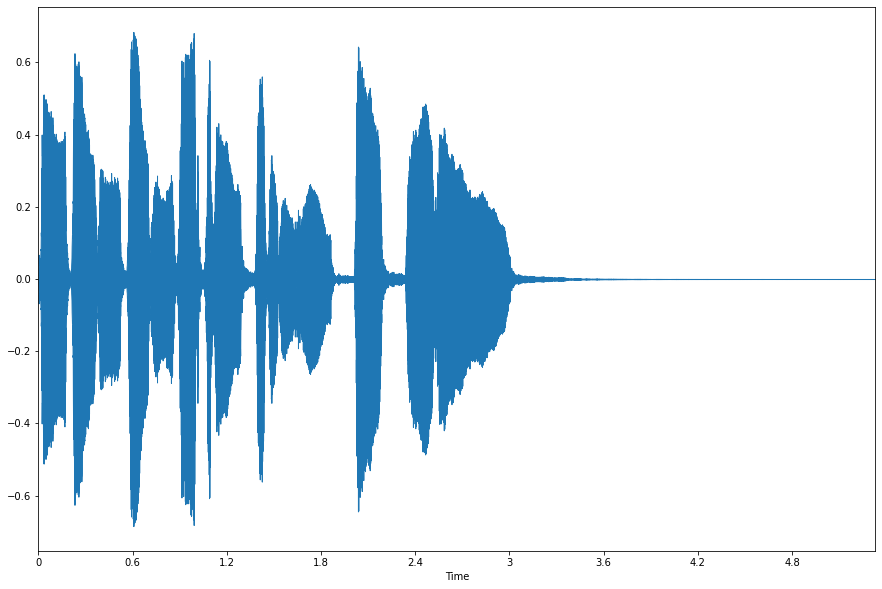

In [8]:
librosa.display.waveplot(x)
#plt.title("Trumpet loop")
#plt.savefig(os.path.join(dest_path, 'waveform.png'))

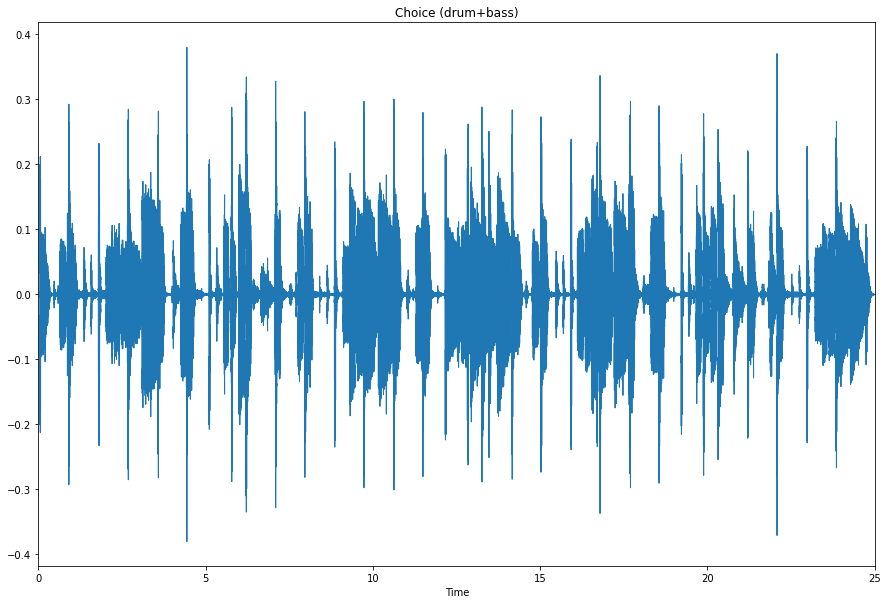

In [31]:
librosa.display.waveplot(x2)
plt.title("Choice (drum+bass)")
plt.savefig(os.path.join(dest_path, 'waveform_choice.png'))

# Energia

In [9]:
N = 1024
w = sp.signal.hann(N)

nov_energia = novidade_energia(x, fs, w)
nov_energia_log = novidade_energia(x, fs, w, log=True)

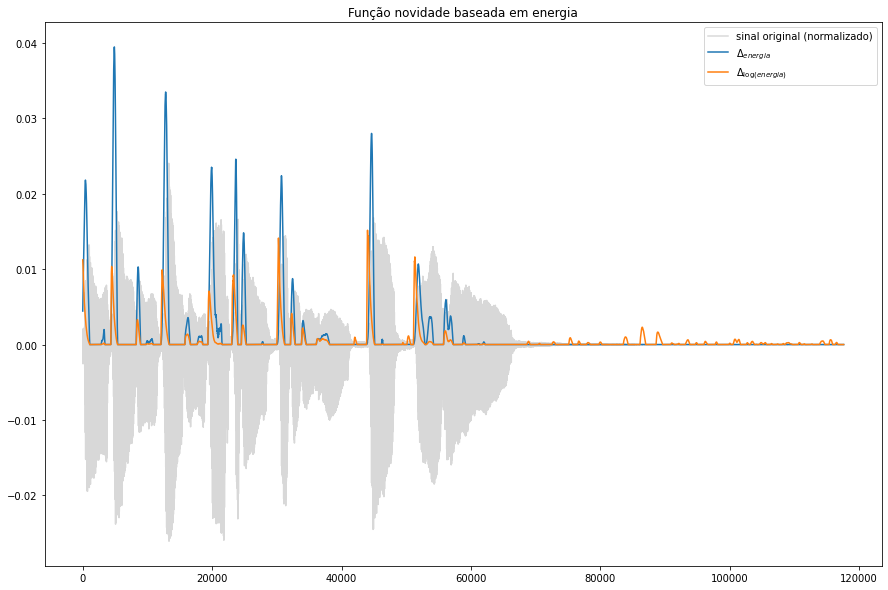

In [25]:
plt.plot(x/np.linalg.norm(x), 'gray', alpha=0.3, label="sinal original (normalizado)")
plt.plot(nov_energia, label='$\Delta_{energia}$')
plt.plot(nov_energia_log, label='$\Delta_{\log{(energia)}}$')
plt.legend()
plt.title('Função novidade baseada em energia')
plt.savefig(os.path.join(dest_path, 'nov_energia.png'))

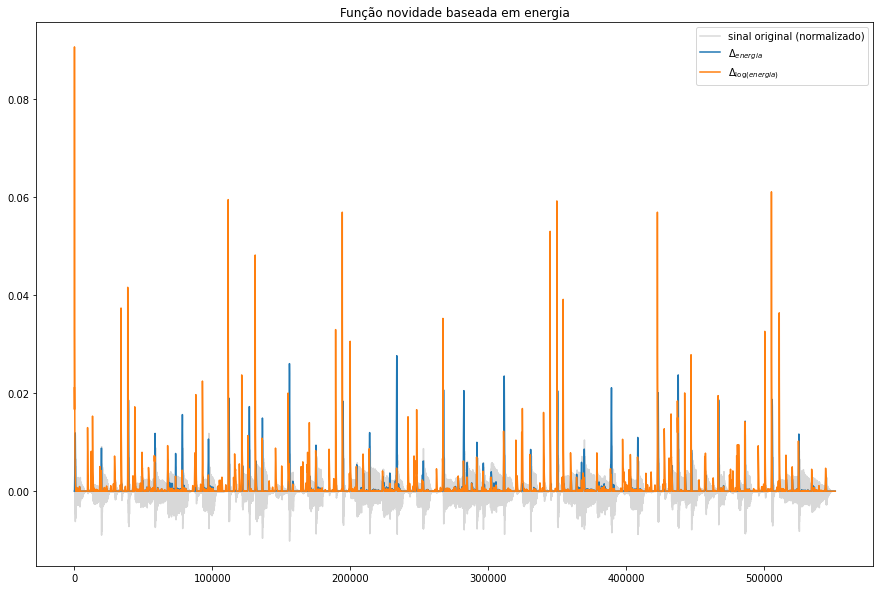

In [43]:
nov_energia2 = novidade_energia(x2, fs2, w)
nov_energia_log2 = novidade_energia(x2, fs2, w, log=True)

plt.plot((x2/np.linalg.norm(x2)), 'gray', alpha=0.3, label="sinal original (normalizado)")
plt.plot(nov_energia2, label='$\Delta_{energia}$')
plt.plot(nov_energia_log2, label='$\Delta_{\log{(energia)}}$')
plt.legend()
plt.title('Função novidade baseada em energia')
plt.savefig(os.path.join(dest_path, 'nov_energia_choice.png'))

# Espectro

In [37]:
N = 1024
H = 256

nov_espectro = novidade_espectro(x, fs, N, H, False)
nov_espectro_1 = novidade_espectro(x, fs, N, H, True, 1)
nov_espectro_10 = novidade_espectro(x, fs, N, H, True, 10)
nov_espectro_100 = novidade_espectro(x, fs, N, H, True, 100)

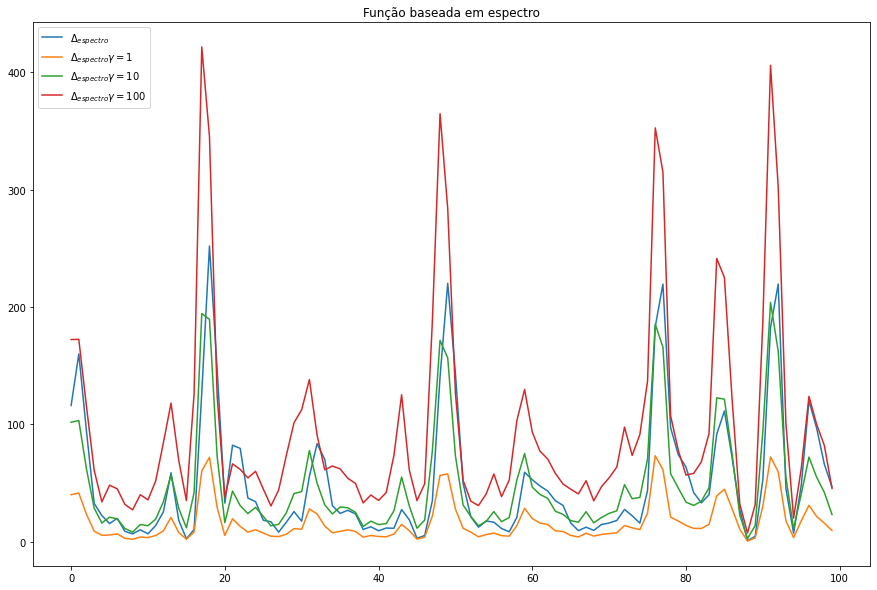

In [38]:
plt.plot(nov_espectro[0:100], label='$\Delta_{espectro}$')
plt.plot(nov_espectro_1[0:100], label='$\Delta_{espectro} \gamma=1$')
plt.plot(nov_espectro_10[0:100], label='$\Delta_{espectro} \gamma=10$')
plt.plot(nov_espectro_100[0:100], label='$\Delta_{espectro} \gamma=100$')
plt.title('Função baseada em espectro')
plt.legend()
#plt.savefig(os.path.join(dest_path, 'nov_espectro.png'))

# Fase

In [39]:
X = librosa.stft(x, n_fft=N, win_length=N, window=w, hop_length=H)

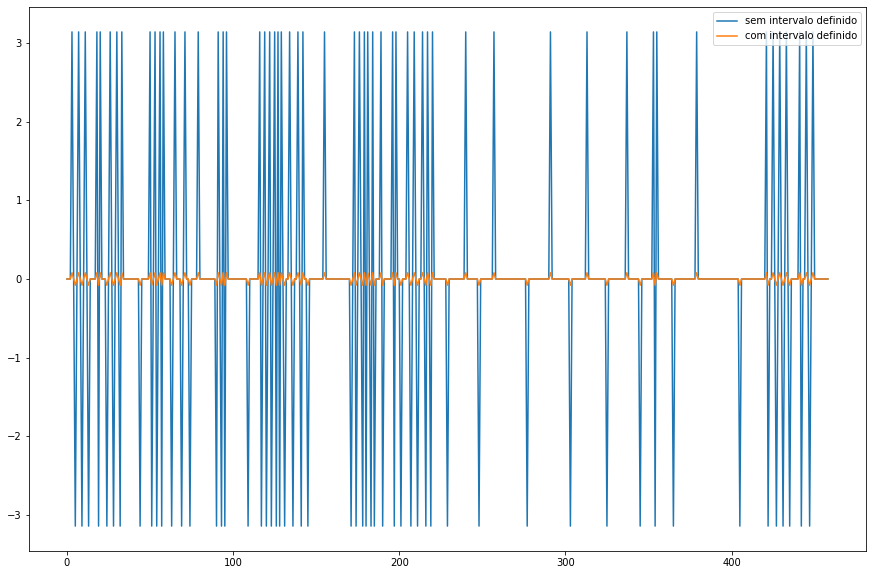

In [40]:
phi = np.angle(X)
phi_2pi = phi/(2*np.pi)
diff = np.diff(phi)
diff_2pi = np.diff(phi_2pi)
plt.plot(diff[0], label="sem intervalo definido")
plt.plot(diff_2pi[0]/(2*np.pi), label="com intervalo definido")
plt.legend()

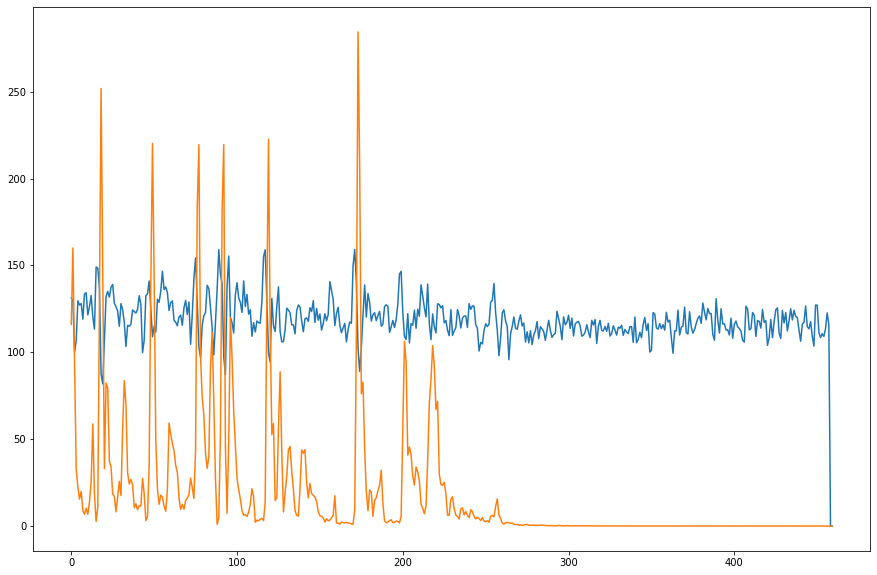

In [41]:
nov_fase = novidade_fase(x, fs, N, H)
plt.plot(nov_fase)
plt.plot(nov_espectro)

# Complexo

In [49]:
w = sp.signal.hann(N)
X = librosa.stft(x, n_fft=N, win_length=N, hop_length=H, window=w)
phi = np.angle(X)/(2*np.pi)

# phase unwrapping (aplicação da função de argumento principal)
argumento_principal = lambda x: np.mod(x + 0.5 , 1) - 0.5

phi_diff = np.diff(argumento_principal(phi), axis=1)

In [50]:
# completando o vetor pra continha ficar mais fácil
phi_diff = np.concatenate((phi_diff, np.zeros((phi.shape[0], 1))), axis=1)

X_hat = np.abs(X)*np.e**(2j*np.pi*(phi + phi_diff))
X_hat = np.abs(X_hat - X)

In [51]:
X_hat.shape
# o numpy não faz a cópia de verdade de um array a não ser que 
# a gente force. caso contrário, ao alterarmos X_plus estaríamos
# alterando também X_hat
X_plus = X_hat.copy()
for n in range(1, X_plus.shape[0]):
    idx = np.where(np.abs(X)[n,:] < np.abs(X)[n-1,:])
    X_plus[n, idx] = 0

In [52]:
novidade_complexo = np.sum(X_plus, axis=1)

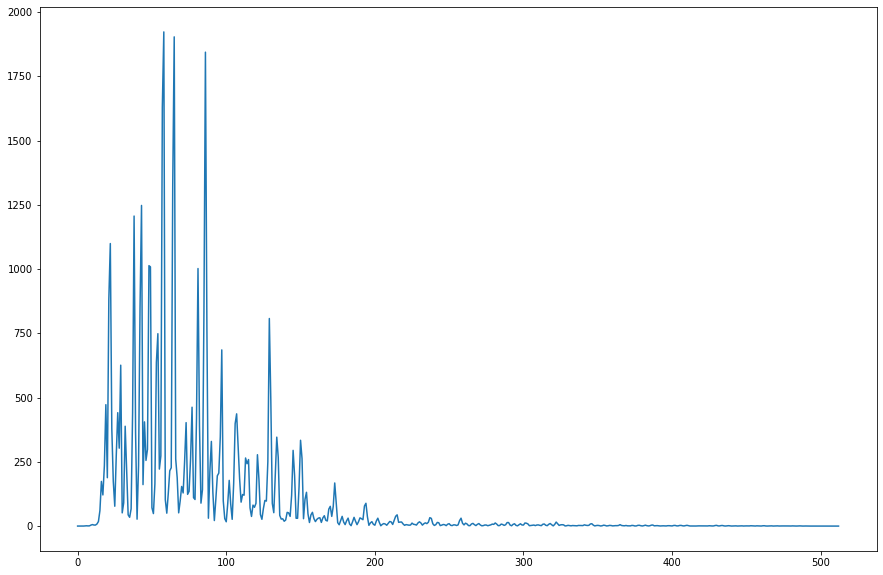

In [53]:
plt.plot(novidade_complexo)